# DOR

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10x10kc250kr.h5ad")):
    !sh /home/jovyan/data/10x10kc250kr.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10x80kc25kr.h5ad")):
    !sh /home/jovyan/data/10x80kc25kr.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/c1htmedium.h5ad")):
    !sh /home/jovyan/data/c1htmedium.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/c1htsmall.h5ad")):
    !sh /home/jovyan/data/c1htsmall.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/celseq2.h5ad")):
    !sh /home/jovyan/data/celseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/dropseq.h5ad")):
    !sh /home/jovyan/data/dropseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/icell8.h5ad")):
    !sh /home/jovyan/data/icell8.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/marsseq.h5ad")):
    !sh /home/jovyan/data/marsseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/quartzseq2.h5ad")):
    !sh /home/jovyan/data/quartzseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/gmcscrbseq.h5ad")):
    !sh /home/jovyan/data/gmcscrbseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/smartseq2.h5ad")):
    !sh /home/jovyan/data/smartseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/singlenuclei.h5ad")):
    !sh /home/jovyan/data/singlenuclei.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/ddseq.h5ad")):
    !sh /home/jovyan/data/ddseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/indrop.h5ad")):
    !sh /home/jovyan/data/indrop.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10xv3.h5ad")):
    !sh /home/jovyan/data/10xv3.sh

In [12]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.preferences import kwarg_savefig

In [3]:
class Config(NamedTuple):
    export: str = "/home/jovyan/output/logistic_model"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [4]:
dsname = {
    "10x10kc250kr": "Chromium V2\n(deep)",
    "10x80kc25kr": "Chromium V2\n(shallow)",
    "singlenuclei": "Chromium V2\n(sn)",
    "10xv3": "Chromium V3",
    "c1htmedium": "C1HT-medium",
    "c1htsmall": "C1HT-small",
    "celseq2": "CEL-seq2",
    "dropseq": "Drop-seq",
    "icell8": "ICELL8",
    "marsseq": "MARS-Seq",
    "quartzseq2": "Quartz-Seq2",
    "gmcscrbseq": "gmcSCRB-seq",
    "ddseq": "ddSEQ",
    "indrop": "inDrop",
    "smartseq2": "Smart-Seq2",
}

In [5]:
def binarize(data, normalizer = None):
    ret = data.copy()
    ret.X = (ret.X != 0)
    ret.var["coverage"] = np.ravel(
        ret.X.sum(axis=0) / ret.shape[0]
    )
    ret.var["DOR"] = 1 - ret.var["coverage"]
    ret.var["Mean"] = np.ravel(
        data.X.mean(axis=0)
    ) if normalizer is None else np.ravel(
        normalizer(data.X).mean(axis=0)
    )
    ret.uns["binarized"] = True
    return ret

In [6]:
from scipy.sparse import coo_matrix

rpm = lambda d: (1e6 * d / d.sum(axis=1))
log2normalize = lambda d: coo_matrix((np.log2(d.data + 1), (d.row, d.col)), shape=d.shape)

In [7]:
bin_datasets = [
    binarize(
        sc.read_h5ad(
            f"/home/jovyan/data/{ds}.h5ad",
            as_sparse=["X"]
        ),
        normalizer=lambda X: log2normalize(rpm(X))
    ) for ds in dsname
]

In [8]:
cov = pd.concat([
    ds.var.assign(
        name=[n for v in range(ds.shape[1])]
    ) for ds, n in zip(bin_datasets, dsname.values())
])

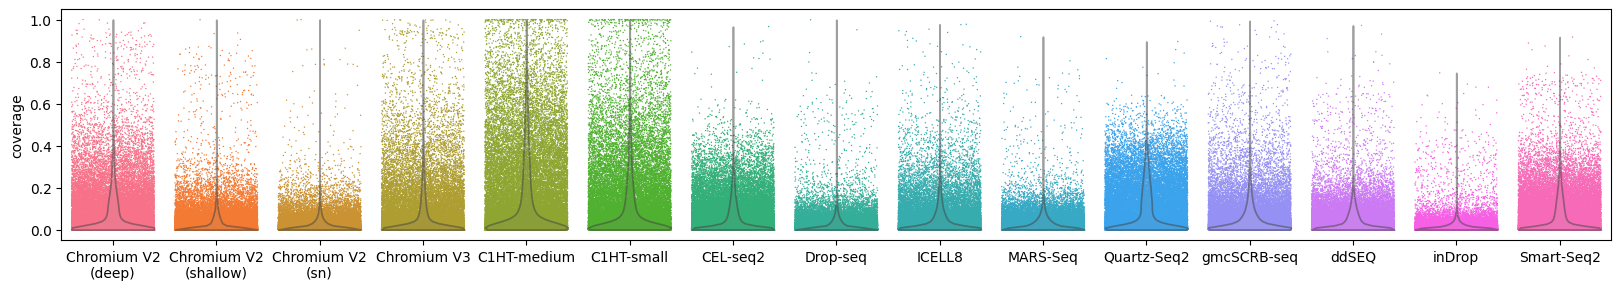

In [13]:
fig, ax = plt.subplots(figsize=(20, 3))

sns.violinplot(
    data=cov,
    y="coverage", hue="name",
    x="name",
    inner=None, cut=0,
    alpha=.5
)
sns.stripplot(
    data=cov,
    y="coverage", hue="name",
    x="name",
    s=1,
    jitter=.4,
    zorder=0
)

ax.set(xlabel="");

fig.savefig(f"{conf.export}/coverage.png", **kwarg_savefig)

In [14]:
meta = pd.concat([
    ds.obs.assign(
        name=[n for v in range(ds.shape[0])]
    ) for ds, n in zip(bin_datasets, dsname.values())
])

/tmp/ipykernel_96870/3077270607.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  ) if np.isnan(meta.groupby("name").min().loc[n, "nUMIs"]) else None
/tmp/ipykernel_96870/3077270607.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  ) if np.isnan(meta.groupby("name").min().loc[n, "nUMIs"]) else None
/tmp/ipykernel_96870/3077270607.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  ) if np.isnan(meta.groupby("name").min().loc[n, "nUMIs"]) else None
/tmp/ipykernel_96870/3077270607.py:22: FutureW

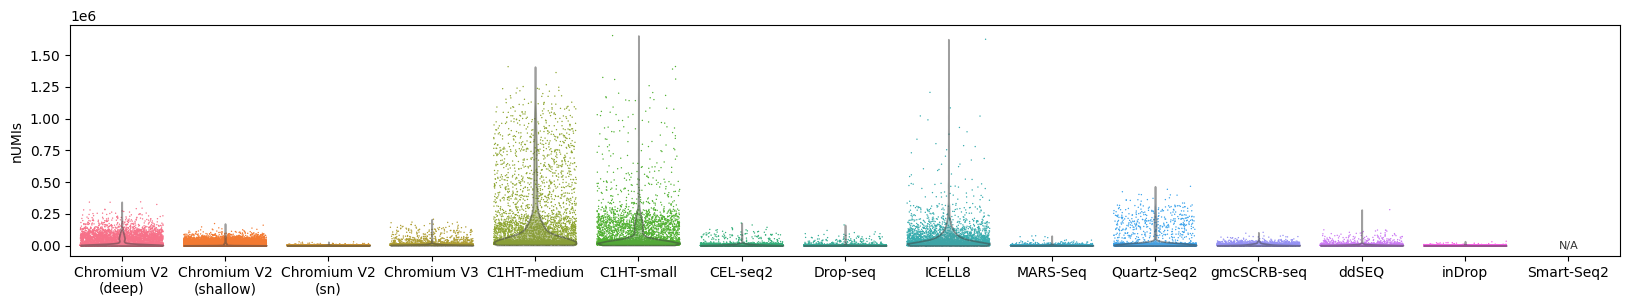

In [58]:
fig, ax = plt.subplots(figsize=(20, 3))

sns.violinplot(
    data=meta,
    y="nUMIs", hue="name",
    x="name",
    inner=None, cut=0,
    alpha=.5
)
sns.stripplot(
    data=meta,
    y="nUMIs", hue="name",
    x="name",
    s=1,
    jitter=.4,
    zorder=0
)

for i, n in enumerate(dsname.values()):
    ax.text(
        i, 0, "N/A", ha="center", va="center", size=8, c=".2"
    ) if np.isnan(meta.groupby("name").min().loc[n, "nUMIs"]) else None

ax.set(xlabel="");

fig.savefig(f"{conf.export}/umi.png", **kwarg_savefig)

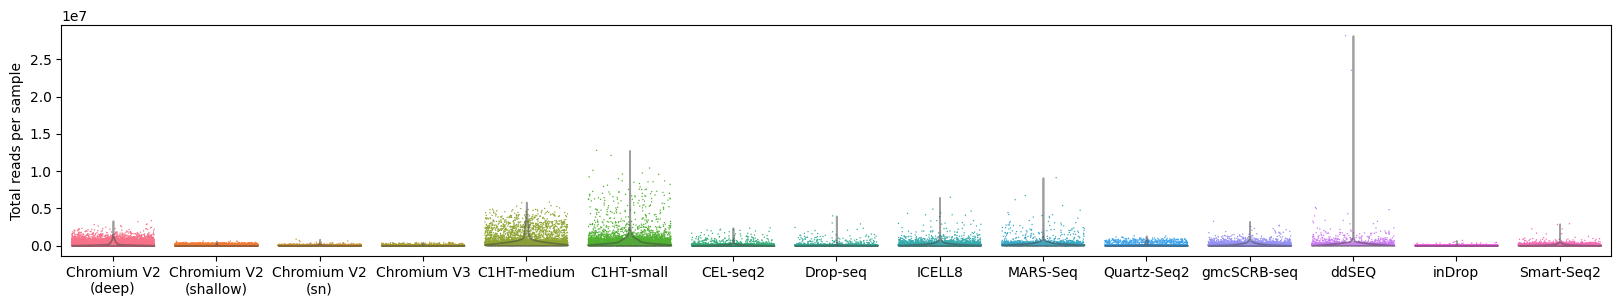

In [69]:
fig, ax = plt.subplots(figsize=(20, 3))

sns.violinplot(
    data=meta,
    y="nTReads", hue="name",
    x="name",
    inner=None, cut=0,
    alpha=.5
)
sns.stripplot(
    data=meta,
    y="nTReads", hue="name",
    x="name",
    s=1,
    jitter=.4,
    zorder=0
)

ax.set(xlabel="", ylabel="Total reads per sample");

fig.savefig(f"{conf.export}/total_reads.png", **kwarg_savefig)

In [70]:
datasize = pd.DataFrame({
    "name": [n.replace("\n", " ") for n in dsname.values()],
    "n_samples": [ds.shape[0] for ds in bin_datasets],
    "nTReads": [ds.obs.nTReads.sum() for ds in bin_datasets]
})

In [71]:
from adjustText import adjust_text

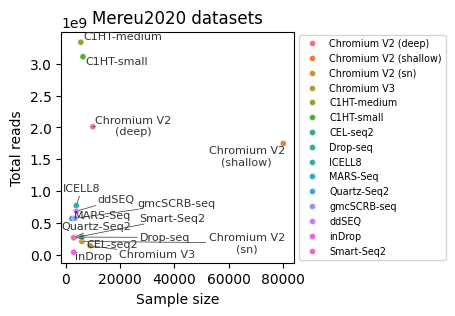

In [72]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(
    data=datasize,
    x="n_samples", y="nTReads",
    hue="name", s=20
)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="x-small")
txt = []
for i, name in enumerate(dsname.values()):
    txt += [ax.text(
        *datasize.loc[i, ["n_samples", "nTReads"]], 
        name,
        size=8, ha="center", va="center",
        c=".2"
    )]

adjust_text(txt, arrowprops=dict(arrowstyle='-', color='.2', lw=0.5))

ax.set(title="Mereu2020 datasets", xlabel="Sample size", ylabel="Total reads")

fig.savefig(f"{conf.export}/scatter.png", **kwarg_savefig)

In [25]:
import json
from typing import Callable, Union

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import r2_score, mean_squared_error


class LogisticModel:
    def __init__(
        self,
        random_state: int = 0,
        n_trials: int = 100,
        search_min: float = 0.,
        search_max: float = 1.
    ) -> None:
        self.seed = random_state
        self.n_trials = n_trials
        self.search_min = search_min
        self.search_max = search_max
        return None
        
    def fit(
        self,
        data: ad.AnnData,
        optimizer: str = "Adagrad",
        lr: float = .1
    ) -> None:
        data = binarize(data) if "binarized" not in data.uns else data
        torch.manual_seed(self.seed)
        b = torch.rand(1, requires_grad=True)
        x = torch.from_numpy(data.var["Mean"].values)
        y = torch.from_numpy(data.var["DOR"].values)

        torch.manual_seed(self.seed)
        optimizer = eval(f"torch.optim.{optimizer}")([b], lr=lr)

        for _ in range(self.n_trials):
            fx = 2 - 2 / (1 + np.e ** (-b * x))
            obj = (
                (fx - y) ** 2
            ).sum()
            obj.backward()
            optimizer.step()
            optimizer.zero_grad()

        self.beta = b.item()
        self.mse = obj.item()
        self.x = x
        self.y = y
        self.f = lambda mean: 2 - 2 / (1 + np.e ** (-self.beta * mean))
        self.y_hat = self.f(self.x)
        self.mse = mean_squared_error(self.y, self.y_hat)
        self.r2_score = r2_score(self.y, 2 - 2 / (1 + np.e ** (-self.beta * self.x)))
        self.predict_mean = lambda dor: (np.log(2 - dor) - np.log(dor)) / self.beta
        
    
    def plot(
        self, 
        ax: plt.Axes = None,
        label: str = None,
        **kwargs
    ) -> None:
        if ax is None:
            _, ax = plt.subplots()
        s = kwargs["s"] if "s" in kwargs else .1
        c = kwargs["c"] if "c" in kwargs else ".6"
        lc = kwargs["linecolor"] if "linecolor" in kwargs else "C0"
        digit = kwargs["round"] if "round" in kwargs else 3
        ndot = kwargs["ndot"] if "ndot" in kwargs else 1000
        ax.scatter(
            1 / (1 + np.e ** (-self.beta * self.x)), 
            self.y, s=s, c=c, label=label
        )
        x = np.linspace(0.5, 1, ndot)
        ax.plot(x, 2 - 2 * x, c=lc, label="$y=-2x+2$")
        ax.set(
            xlabel="$1/(1+e^{-b\cdot Mean})$", ylabel="$DOR$", 
            title="$b="+f"{round(self.beta, digit)},"+"\;R^2="+f"{self.r2_score.round(digit)}$"
        )
        ax.legend()
    
    
    def residual_plot(
        self, 
        ax: plt.Axes = None,
        label: str = None,
        **kwargs
    ) -> None:
        if ax is None:
            _, ax = plt.subplots()
        s = kwargs["s"] if "s" in kwargs else .1
        c = kwargs["c"] if "c" in kwargs else ".6"
        lc = kwargs["linecolor"] if "linecolor" in kwargs else "C0"
        ndot = kwargs["ndot"] if "ndot" in kwargs else 1000
        ax.scatter(self.x, self.y - self.y_hat, s=s, c=c, label=label)
        x = np.linspace(self.x.min(), self.x.max(), ndot)
        ax.plot(x, np.zeros(x.size), c=lc, label="$y=0$")
        ax.set(xlabel="$Mean$", ylabel="Residual errors", title="Residual plot")
        ax.legend()


    def calibration_plot(
        self,
        ax: plt.Axes = None,
        hide_curve: bool = False,
        label: str = None,
        **kwargs
    ) -> None:
        if ax is None:
            _, ax = plt.subplots()
        s = kwargs["s"] if "s" in kwargs else .1
        c = kwargs["c"] if "c" in kwargs else ".6"
        lc = kwargs["linecolor"] if "linecolor" in kwargs else "C0"
        ndot = kwargs["ndot"] if "ndot" in kwargs else 1000
        ln = kwargs["linelabel"] if "linelabel" in kwargs else "$y=-2/(1+e^{-b\cdot Mean})+2$"
        ax.scatter(self.x, self.y, s=s, c=c, label=label)
        if not hide_curve:
            x = np.linspace(self.x.min(), self.x.max(), ndot)
            ax.plot(x, self.f(x), c=lc, label=ln)

        ax.set(xlabel="$Mean$", ylabel="$DOR$")
        if not hide_curve:
            ax.legend()

In [27]:
import optuna
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [30]:
from sklearn.metrics import mean_squared_error as mse

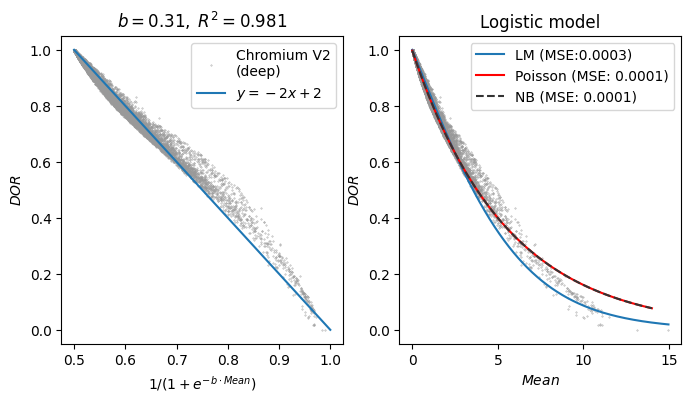

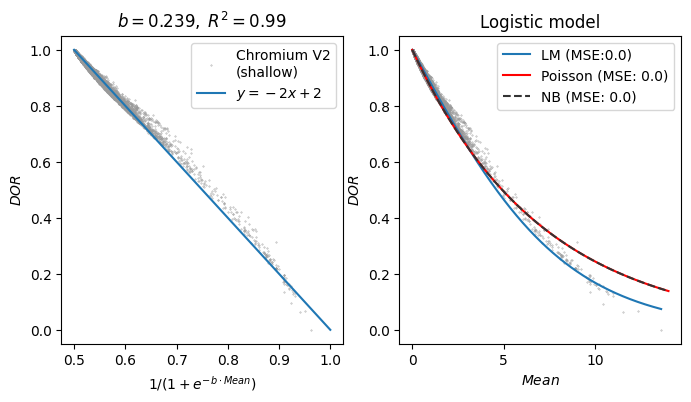

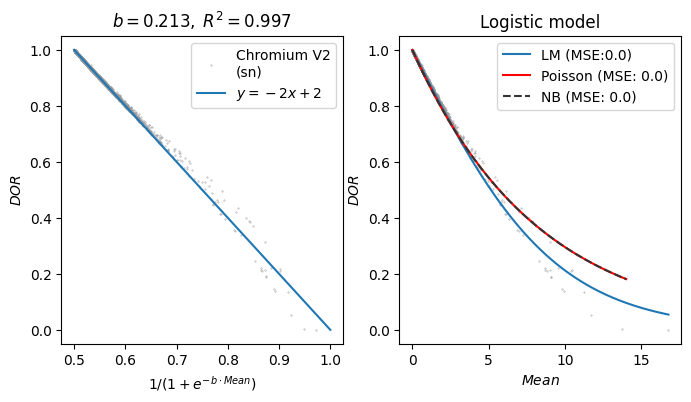

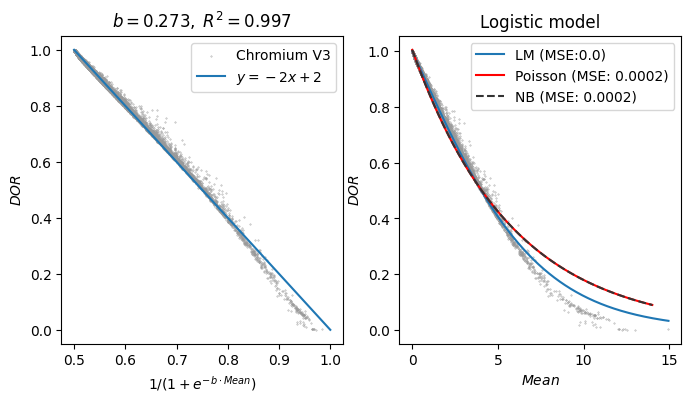

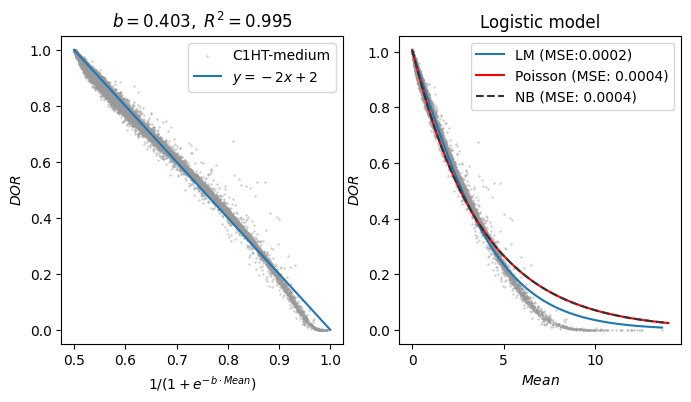

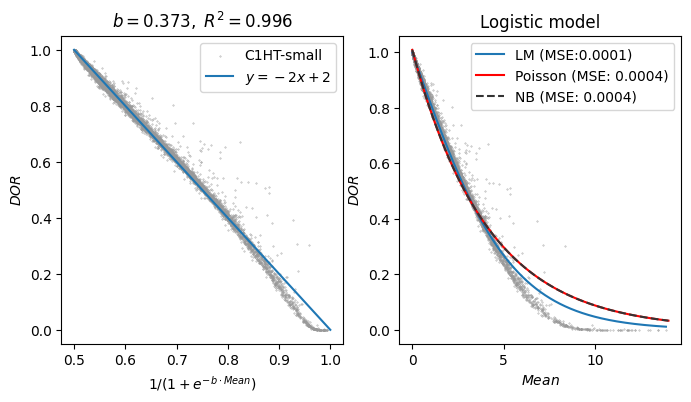

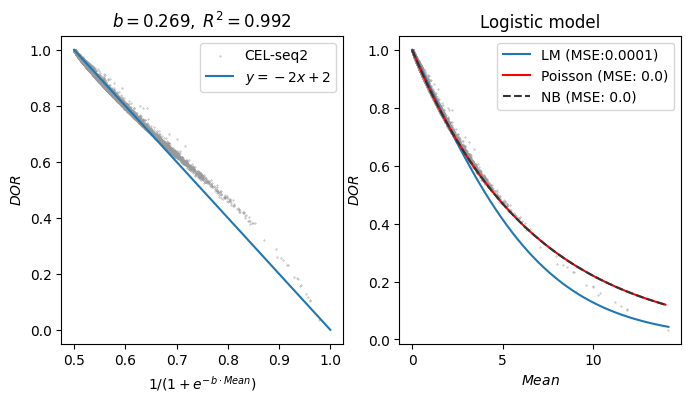

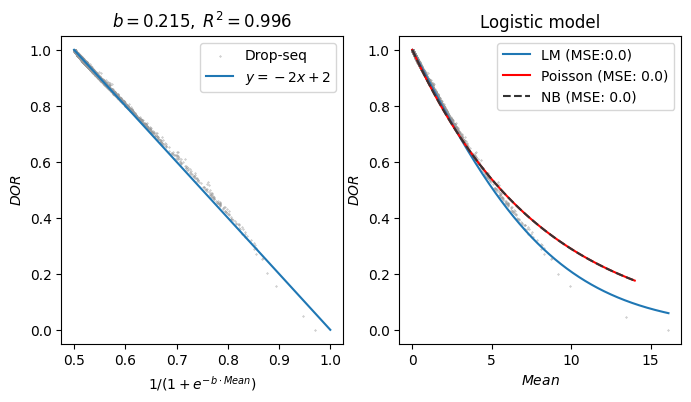

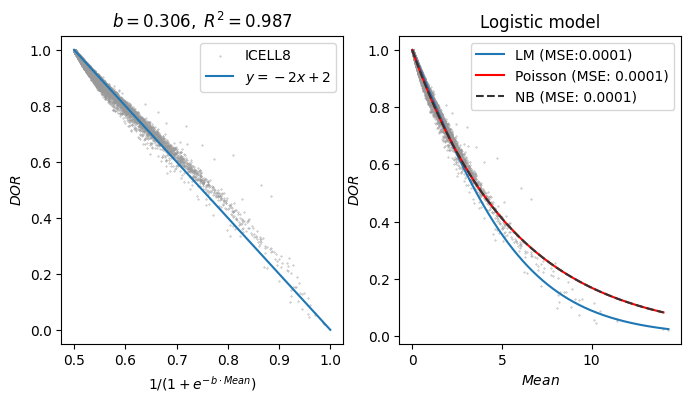

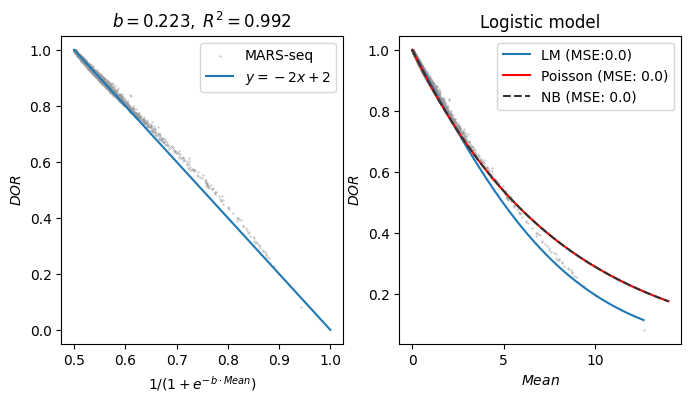

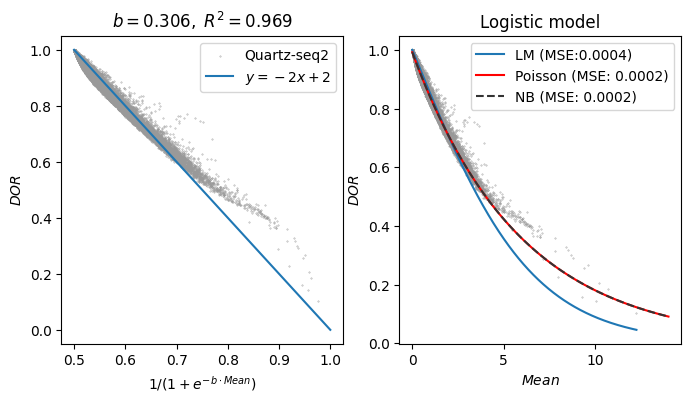

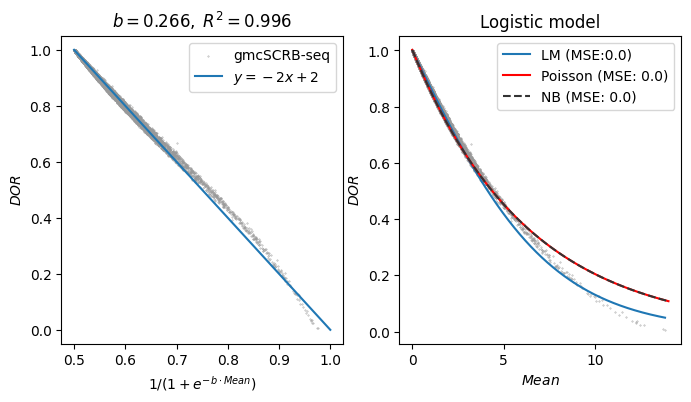

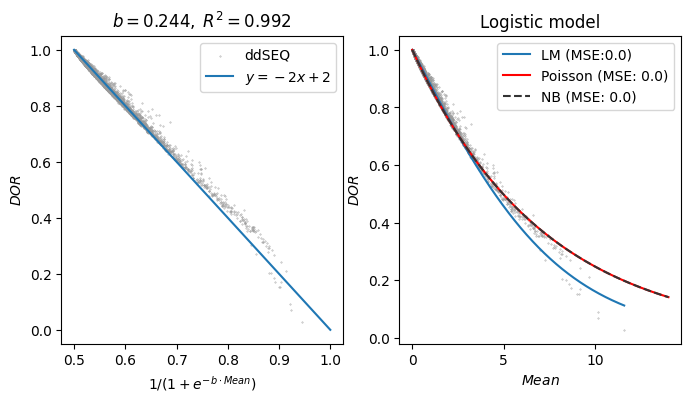

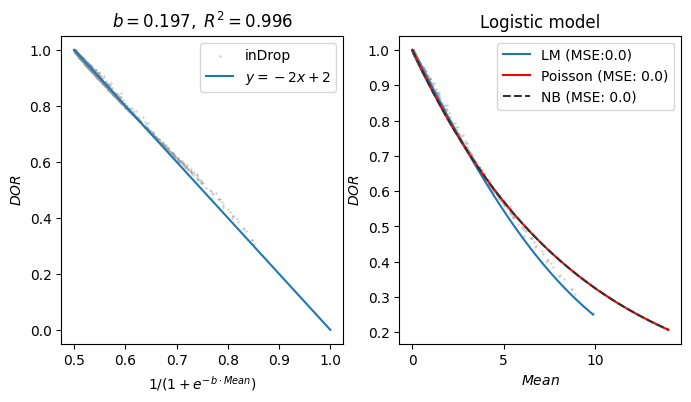

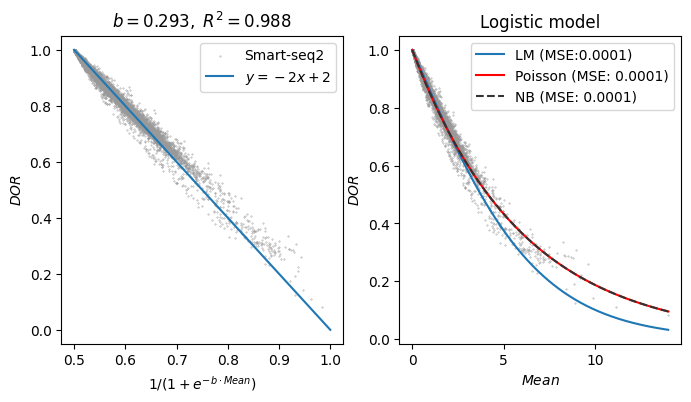

In [35]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

for ds, n in zip(bin_datasets, dsname.values()):
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    lm = LogisticModel()
    lm.fit(ds)
    lm.plot(ax=ax[0], label=n)
    lm.calibration_plot(ax=ax[-1], linelabel=f"LM (MSE:{lm.mse.round(4)})")
    ax[-1].set(title="Logistic model")
    
    endog = ds.var["DOR"].values
    exog = sm.add_constant(ds.var["Mean"].values)

    link = sm.genmod.families.links.Log()

    def objective(trial):
        alpha = trial.suggest_float('alpha', .01, 2)
        nb = sm.GLM(endog, exog, family=sm.families.NegativeBinomial(alpha=alpha, link=link))
        return nb.fit().aic

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=200)
    alpha = study.best_params['alpha']

    poi = sm.GLM(endog=endog, exog=exog, family=sm.families.Poisson(link=link))
    nb = sm.GLM(endog=endog, exog=exog, family=sm.families.NegativeBinomial(link=link, alpha=alpha))
    res_poi = poi.fit()
    res_nb = nb.fit()
    
    sns.lineplot(
        x=np.linspace(0, 14, 100),
        y=res_poi.predict(sm.add_constant(np.linspace(0, 14, 100))),
        label=f"Poisson (MSE: {mse(lm.y, res_poi.predict(sm.add_constant(lm.x))).round(4)})",
        c="r", ax=ax[1]
    )
    sns.lineplot(
        x=np.linspace(0, 14, 100),
        y=res_nb.predict(sm.add_constant(np.linspace(0, 14, 100))),
        label=f"NB (MSE: {mse(lm.y, res_nb.predict(sm.add_constant(lm.x))).round(4)})",
        linestyle="--", c=".2", ax=ax[1]
    )

# fig.savefig(f"{conf.export}/calibration_curve.png", **kwarg_savefig)